## The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import os
import math
import cv2
import glob
import zipfile
import scipy
import pickle
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from moviepy.editor import VideoFileClip
from urllib.request import urlretrieve
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline

## Download dataset


In [9]:
# Helper functions
car_label = 1
notcar_label = 0

def download(url):
    # Get file name
    file = url.rsplit('/', 1)[-1]
    
    # Download
    print('Downloading ' + file + '...')
    if not os.path.isfile(file):
        urlretrieve(url, file)
        print('Download Finished')
    else:
        print('File already in the filesystem!')
        

def unzip(file):
    if not os.path.isdir(os.path.splitext(file)[0]):        
        print('Unzipping ' + file + '...')
        with zipfile.ZipFile(file,"r") as zip_ref:
            zip_ref.extractall()
    else:
        print('File ' + file + ' already unpacked!')

def save_image(fig_handler, fname):
    out_folder = './output_images'
    # Get plot by its id number
    plt.figure(fig_handler.number)
    plt.savefig(os.path.join(out_folder, fname + '.jpg'), bbox_inches='tight')


In [3]:
vehicles_file = 'vehicles.zip'
non_vehicles_file = 'non-vehicles.zip'
download_url_base = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/'

download(url = download_url_base + vehicles_file)
download(url = download_url_base + non_vehicles_file)

unzip(vehicles_file)
unzip(non_vehicles_file)

File already in the filesystem!
File already in the filesystem!
File vehicles.zip already unpacked!
File non-vehicles.zip already unpacked!


In [4]:
car_files = glob.glob('vehicles/**/*.png')
notcar_files = glob.glob('non-vehicles/**/*.png')

print("Vehicle training data:", len(car_files))
print("Non-Vehicle training data:", len(notcar_files))

print('N samples', str(len(car_files) + len(notcar_files)))

Vehicle training data: 8792
Non-Vehicle training data: 8968
N samples 17760


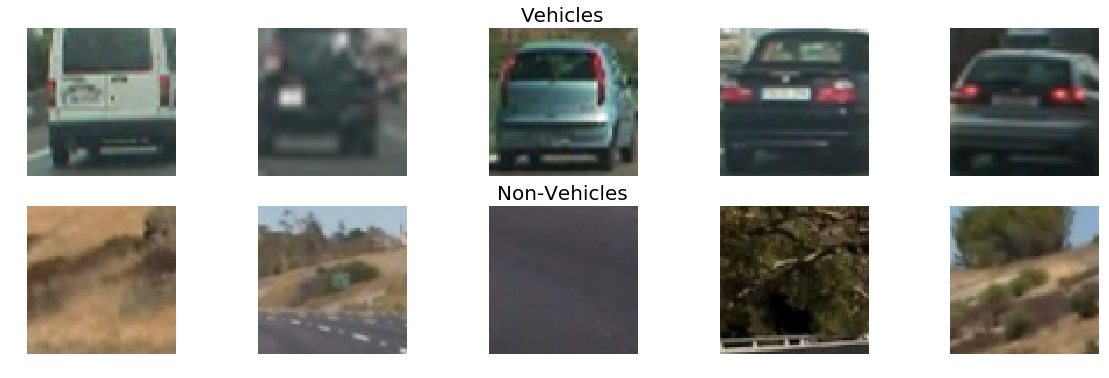

In [5]:
f, axarr = plt.subplots(2, 5, figsize=(20, 6))

# Vehicle example images
for i in range(5):
    random_img = random.randint(0, 1000)
    example_car = scipy.misc.imread(car_files[random_img])
    axarr[0,i].imshow(example_car)
    axarr[0,i].set_axis_off()
    axarr[0,2].set_title('Vehicles', fontsize=20)
    
# Non-Vehicle example images
for i in range(5):
    random_img = random.randint(0, 1000)
    example_notcar = scipy.misc.imread(notcar_files[random_img])
    plt.imshow(example_notcar)
    axarr[1,i].imshow(example_notcar)
    axarr[1,i].set_axis_off()
    axarr[1,2].set_title('Non-Vehicles', fontsize=20)
 
save_image(f, 'dataset_overview')

## Feature extraction

### Helper functions

In [2]:
## Helper functions obtained from lectures and quizzes

# Returns HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, transf_sqrt=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=transf_sqrt, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=transf_sqrt, 
                       visualise=vis, feature_vector=feature_vec)
        return features


# Computes binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Computes color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


### Check - Visualize HOG features

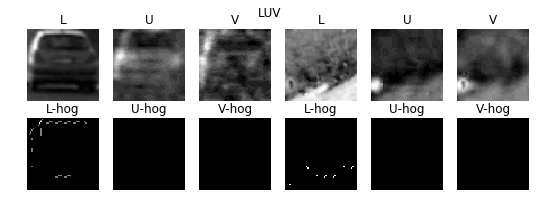

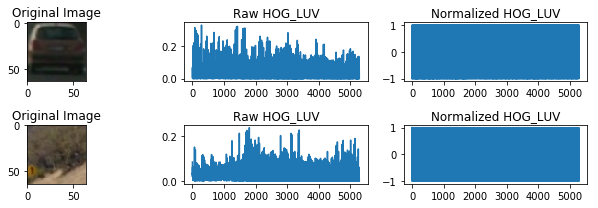

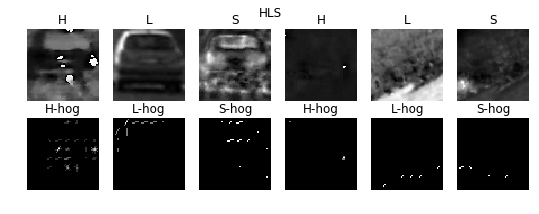

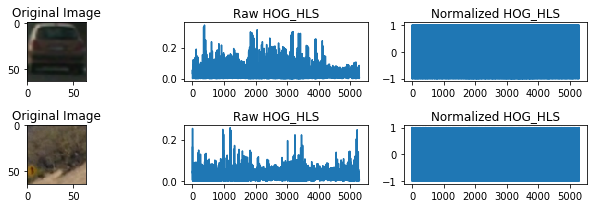

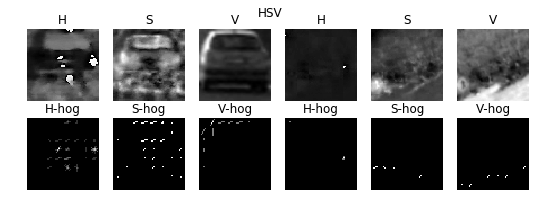

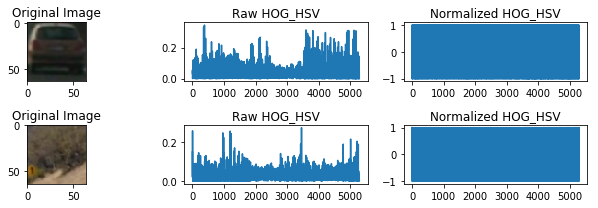

In [126]:
# Check HOG features
def check_hog_features(img, color_space, orient, pix_per_cell, cell_per_block, 
                       hog_channel="ALL", transf_sqrt=True):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
        
    
    
    if hog_channel == "ALL":
        hog_features = []
        hog_image = np.zeros_like(feature_image)
        for channel in range(feature_image.shape[2]):
            hog_features_i, hog_image[:, :, channel] = get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                transf_sqrt=transf_sqrt, vis=True, feature_vec=True)
            hog_features.append(hog_features_i)
            
        hog_features = np.ravel(hog_features) 
        #hog_features = np.stack(hog_features, axis=-1)
    else:
        hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, transf_sqrt=transf_sqrt, vis=True, feature_vec=True)
    
    return hog_features, hog_image, feature_image


def show_hog_images(colorspace, car_feature_image, car_hog_image, notcar_feature_image, notcar_hog_image):
    f, axarr = plt.subplots(2, 6, figsize=(9, 3))
    f.suptitle(colorspace)
    # Show features
    for i in range(3):
        axarr[0,i].imshow(car_feature_image[:, :, i], cmap='gray')
        axarr[0,i].set_axis_off()
        axarr[0,i].set_title(colorspace[i])

        axarr[1,i].imshow(car_hog_image[:, :, i], cmap='gray')
        axarr[1,i].set_axis_off()
        axarr[1,i].set_title(colorspace[i]+'-hog')

        axarr[0,i+3].imshow(notcar_feature_image[:, :, i], cmap='gray')
        axarr[0,i+3].set_axis_off()
        axarr[0,i+3].set_title(colorspace[i])

        axarr[1,i+3].imshow(notcar_hog_image[:, :, i], cmap='gray')
        axarr[1,i+3].set_axis_off()
        axarr[1,i+3].set_title(colorspace[i]+'-hog')
        
    save_image(f, ('hog_visualization_' + colorspace))

def show_features(car_features, notcar_features, car_example, notcar_example, title='', fig_size=(9,3)):
    if len(car_features) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        car_ind = 0
        
        # Plot an example of raw and scaled features
        fig = plt.figure(figsize=fig_size)
        plt.subplot(231)
        plt.imshow(car_example)
        plt.title('Original Image')
        plt.subplot(232)
        plt.plot(X[car_ind])
        plt.title('Raw ' + title)
        plt.subplot(233)
        plt.plot(scaled_X[car_ind])
        plt.title('Normalized ' + title)
        fig.tight_layout()

        # Plot an example of raw and scaled features
        notcar_ind = 0
        plt.subplot(234)
        plt.imshow(notcar_example)
        plt.title('Original Image')
        plt.subplot(235)
        plt.plot(X[1])
        plt.title('Raw ' + title)
        plt.subplot(236)
        plt.plot(scaled_X[1])
        plt.title('Normalized ' + title)
        fig.tight_layout()
        
        save_image(fig, ('features_' + title))
        
    else: 
        print('Your function only returns empty feature vectors...')



# Vehicle and Non-Vehicle examples
car_example_file = car_files[564] #564
notcar_example_file = notcar_files[838] #838 #120 #342
car_example = scipy.misc.imread(car_example_file)
notcar_example = scipy.misc.imread(notcar_example_file)


# Tweak these parameters and see how the results change.
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

# Check RGB hog features
colorspace='LUV'
hog_channel = "ALL"
car_hog_features, car_hog_image, car_feature_image = check_hog_features(car_example, colorspace, orient, 
                        pix_per_cell, cell_per_block, hog_channel=hog_channel)

notcar_hog_features, notcar_hog_image, notcar_feature_image = check_hog_features(notcar_example, colorspace, orient, 
                        pix_per_cell, cell_per_block, 
                        hog_channel=hog_channel)

show_hog_images(colorspace, car_feature_image, car_hog_image, notcar_feature_image, notcar_hog_image)
show_features(car_hog_features, notcar_hog_features, car_example, notcar_example, title=('HOG_' + colorspace))

# Check HLS hog features
colorspace='HLS'
hog_channel = "ALL" #2
car_hog_features, car_hog_image, car_feature_image = check_hog_features(car_example, colorspace, orient, 
                        pix_per_cell, cell_per_block, hog_channel=hog_channel)


notcar_hog_features, notcar_hog_image, notcar_feature_image = check_hog_features(notcar_example, colorspace, orient, 
                        pix_per_cell, cell_per_block, 
                        hog_channel=hog_channel)

show_hog_images(colorspace, car_feature_image, car_hog_image, notcar_feature_image, notcar_hog_image)
show_features(car_hog_features, notcar_hog_features, car_example, notcar_example, title=('HOG_' + colorspace))



# Check HSV hog features
colorspace='HSV'
hog_channel = "ALL" #0
car_hog_features, car_hog_image, car_feature_image = check_hog_features(car_example, colorspace, orient, 
                        pix_per_cell, cell_per_block, hog_channel=hog_channel)


notcar_hog_features, notcar_hog_image, notcar_feature_image = check_hog_features(notcar_example, colorspace, orient, 
                        pix_per_cell, cell_per_block, 
                        hog_channel=hog_channel)

show_hog_images(colorspace, car_feature_image, car_hog_image, notcar_feature_image, notcar_hog_image)
show_features(car_hog_features, notcar_hog_features, car_example, notcar_example, title=('HOG_' + colorspace))

### Check - Visualize spatial features

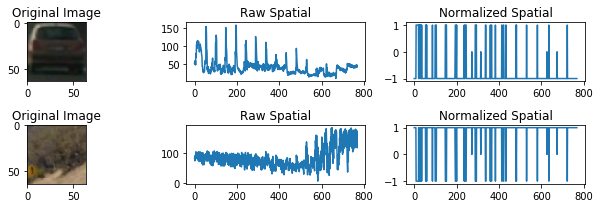

In [93]:
# Tweak these parameters and see how the results change.
spatial_size = (16, 16) # Spatial binning dimensions

car_spatial_features = bin_spatial(car_example, size=spatial_size)
notcar_spatial_features = bin_spatial(notcar_example, size=spatial_size)

show_features(car_spatial_features, notcar_spatial_features, car_example, notcar_example, title='Spatial')


### Check - Visualize color-histogram features

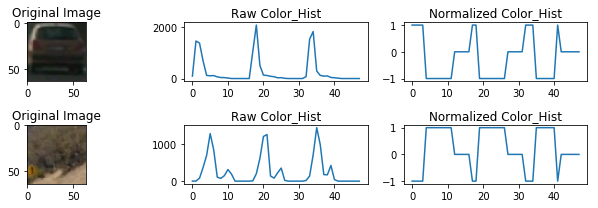

In [94]:
# Tweak these parameters and see how the results change.
hist_bins = 16   # Number of histogram bins

car_color_features = color_hist(car_example, nbins=hist_bins)
notcar_color_features = color_hist(notcar_example, nbins=hist_bins)

show_features(car_color_features, notcar_color_features, car_example, notcar_example, title='Color_Hist')

### Define final hyperparameters

In [3]:
## Final parameters, chosen from test above

colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


### HOG and color features extraction

In [120]:
# Extracts features from a list of images
# Calls get_hog_features(), bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = scipy.misc.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)     

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == "ALL":
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

N features: 6108


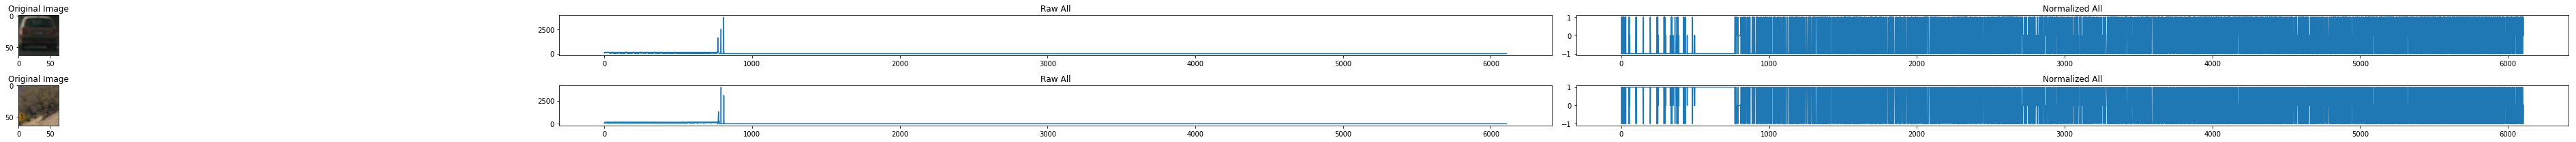

In [96]:
# Check extract features
cars = []
cars.append(car_example_file)

notcars = []
notcars.append(notcar_example_file)


car_features = extract_features(cars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

assert(len(car_features[0]) == len(notcar_features[0]))
print('N features:', len(car_features[0]))


show_features(car_features, notcar_features, car_example, notcar_example, title='All', fig_size=(62,3))


## Classifier

### Extract features from training set

In [97]:
features_file = 'features.pickle'

def extract_features_dataset():

    # Features were already extracted
    if not os.path.exists(features_file):
        print('Extracting features...')
        t=time.time()
        car_features = extract_features(car_files, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        notcar_features = extract_features(notcar_files, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        t2 = time.time()
        print('Done')
        print(round(t2-t, 2), 'Seconds to extract features.')
        
        
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
        
        print('Saving features in ' + features_file + '...')
        pickle.dump((X, y), open(features_file, 'wb'))
        print('Done')
    else:
        print('Features already extracted. Saved in ' + features_file)

def load_features_dataset():
    if os.path.exists(features_file):
        print('Loading features from ' + features_file + '...')
        X, y = pickle.load(open(features_file, 'rb'))
        print('Done')
        return X, y
        
    else:
        print(features_file + ' does not exist!')
        

extract_features_dataset()
X, y = load_features_dataset()

print('N samples:', X.shape[0])
print('N features:', X.shape[1])
assert(X.shape[0] == y.shape[0])

Features already extracted. Saved in features.pickle
Loading features from features.pickle...
Done
N samples: 17760
N features: 6108


### Combine and normalize features

In [98]:
def combine_normalize_features(X):
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    return X_scaler, scaled_X

# Split up data into randomized training and test sets
scaler, scaled_X = combine_normalize_features(X)
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('N samples:', X_train.shape[0])
print('N features:', X_train.shape[1])


Using: 9 orientations 8 pixels per cell and 2 cells per block
N samples: 14208
N features: 6108


### Train classifier

In [99]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Calculate classifier accuracy
svc_accuracy = round(svc.score(X_test, y_test), 4)

# Check the score of the SVC
print('Test Accuracy of SVC = ', svc_accuracy)

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# Save if classifier is accurate enough
acc_treshold = 0.99
svc_file = 'svc_classifier.pickle'

if (svc_accuracy > acc_treshold):
    print('Saving SCV classifier...')
    
    pickle.dump((svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, colorspace), open(svc_file, 'wb'))
    print('Done')
                            
    
else:
    print('Classifier test accuracy is less than ' + acc_treshold)
    print('Not good enough! Try again!')
    

21.06 Seconds to train SVC...
Test Accuracy of SVC =  0.9927
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
0.00403 Seconds to predict 10 labels with SVC
Saving SCV classifier...
Done


### Check - Predict single image

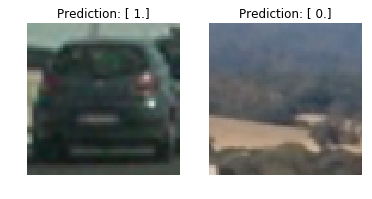

In [100]:
# Vehicle and Non-Vehicle examples
car_example_file = car_files[234]
notcar_example_file = notcar_files[342] #342

# Extract features from files
cars, notcars = [], []
cars.append(car_example_file)
notcars.append(notcar_example_file)


car_features = extract_features(cars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X_predict = np.vstack((car_features, notcar_features)).astype(np.float64)                        

y_car_predicted = svc.predict(X_predict[0])
y_notcar_predicted = svc.predict(X_predict[1])

fig = plt.figure()
plt.subplot(1,2,1);
plt.imshow(scipy.misc.imread(car_example_file))
plt.axis('off')
plt.title('Prediction: ' + str(y_car_predicted))

plt.subplot(1,2,2);
plt.imshow(scipy.misc.imread(notcar_example_file))
plt.axis('off')
plt.title('Prediction: ' + str(y_notcar_predicted))

save_image(fig, 'prediction')

## Sliding windows

### Load SVM data

In [4]:
svc_file = 'svc_classifier.pickle'
if os.path.exists(svc_file):
    print('Loading existing classifier data...')
    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, colorspace = pickle.load(open(svc_file, "rb" ))
    print('Done')
else:
    print('File does not exist', svc_file)
    

Loading existing classifier data...
Done


### Detect cars on sliding windows 

In [5]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)  
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
        
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
        
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

   
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


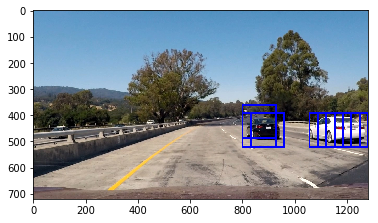

In [6]:
image_file = './test_images/test1.jpg'
image = scipy.misc.imread(image_file)
draw_image = np.copy(image)
height, width = image.shape[0:2]

# Parameters
y_start_stop = [height//2, height]
xy_window=(128, 128)
xy_overlap=(0.75, 0.75)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=xy_overlap)
                       
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

### Hog Sub-sampling window search

In [7]:
# Functions adapted from lectures

# Extracts hog features once and then can be sub-sampled to get all of its overlaying windows. Then make predictions
def find_cars(img, window, cells_per_step, ystart, ystop, scale, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
              color_space, hog_channel, spatial_feat, hist_feat, hog_feat, show_all_windows=False):
    
    # Empty list to receive positive detection windows
    on_windows = []
    
    img_tosearch = img[ystart:ystop,:,:]
    
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)
            
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1     
    
    nblocks_per_window = (window // pix_per_cell) - 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            # Empty list to receive features of each window
            features_patch = []

            # Extract the image patch
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))
          
            # Get color features
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                features_patch.append(spatial_features)
                
            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)
                features_patch.append(hist_features)
                            
            # Extract HOG features for this patch - subsample
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
                
            features_patch.append(hog_features)

            # Scale features and make a prediction
            features_tuple = tuple(features_patch)
            window_features = X_scaler.transform(np.hstack((spatial_features, hist_features,hog_features)).reshape(1, -1))    
            window_prediction = svc.predict(window_features)
            
            if window_prediction == 1 or show_all_windows:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart)))


    return on_windows

### Multi-scale sliding windows

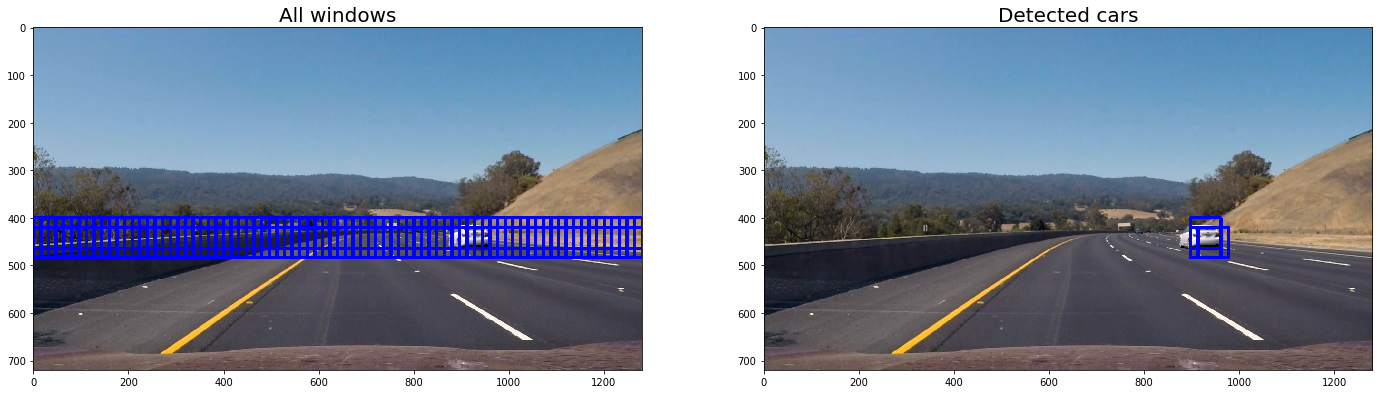

In [19]:
# Smaller cars appear near the horizon

image_file = './test_images/test3.jpg'
image = scipy.misc.imread(image_file)
draw_image = np.copy(image)

all_rectangles = []
on_windows = []

# Parameters
window = 64 # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
cells_per_step = 2  # Instead of overlap, define how many cells to step => 75% overlap

ystart = 400
ystop = 465
scale = 1.0 # small rectangles

all_rectangles.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=True))
on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))

ystart = 420
ystop = 485
scale = 1.0
all_rectangles.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=True))
on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))


rectangles = [item for sublist in all_rectangles for item in sublist] 
active_rectangles = [item for sublist in on_windows for item in sublist]

fig = plt.figure(figsize=(24,9))
plt.subplot(1,2,1)
test_out = draw_boxes(image, rectangles, (0,0,255), 6)
plt.imshow(test_out)
plt.title('All windows',fontsize=20)
plt.subplot(1,2,2);
test_out = draw_boxes(image, active_rectangles, (0,0,255), 6)
plt.imshow(test_out)
plt.title('Detected cars',fontsize=20)

save_image(fig, 'multiscaleWindows_far')

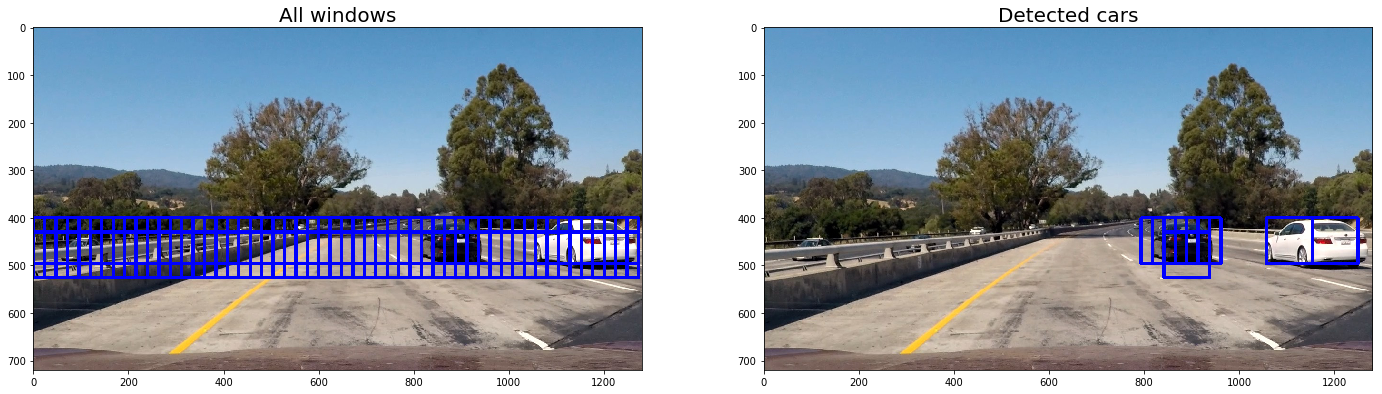

In [146]:
# Test - Intermediate distance 1

image_file = './test_images/test1.jpg'
image = scipy.misc.imread(image_file)


all_rectangles = []
on_windows = []

# Parameters
ystart = 400
ystop = 500
scale = 1.5

all_rectangles.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=True))
on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))

ystart = 430
ystop = 530
scale = 1.5

all_rectangles.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=True))
on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))

rectangles = [item for sublist in all_rectangles for item in sublist] 
active_rectangles = [item for sublist in on_windows for item in sublist]

fig = plt.figure(figsize=(24,9))
plt.subplot(1,2,1)
test_out = draw_boxes(image, rectangles, (0,0,255), 6)
plt.imshow(test_out)
plt.title('All windows',fontsize=20)
plt.subplot(1,2,2);
test_out = draw_boxes(image, active_rectangles, (0,0,255), 6)
plt.imshow(test_out)
plt.title('Detected cars',fontsize=20)

save_image(fig, 'multiscaleWindows_intermediate1')

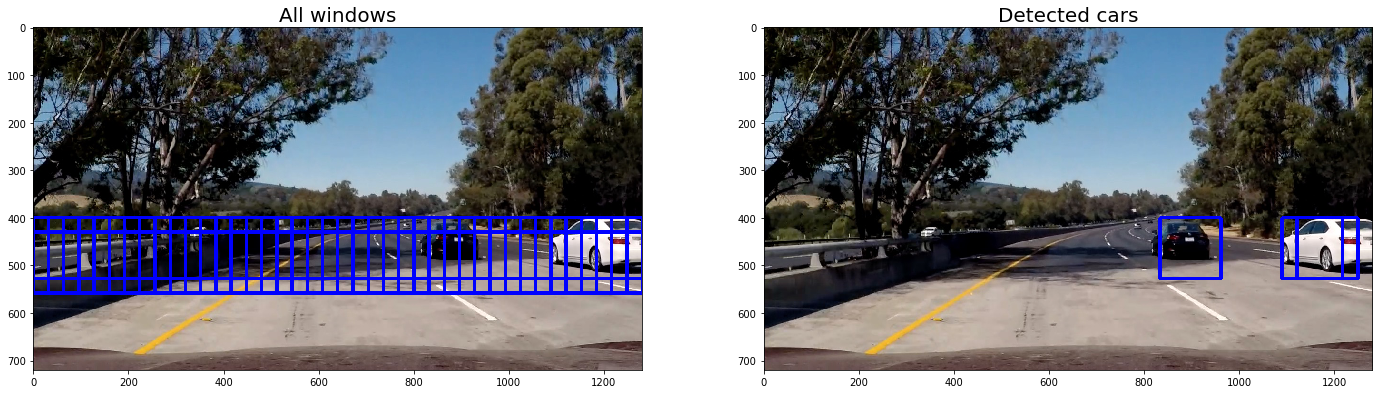

In [107]:
# Test - Intermediate distance 2

image_file = './test_images/test5.jpg'
image = scipy.misc.imread(image_file)


all_rectangles = []
on_windows = []

# Parameters
ystart = 400
ystop = 530
scale = 2.0

all_rectangles.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=True))
on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))

ystart = 430
ystop = 560
scale = 2.0

all_rectangles.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=True))
on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))

rectangles = [item for sublist in all_rectangles for item in sublist] 
active_rectangles = [item for sublist in on_windows for item in sublist]

fig = plt.figure(figsize=(24,9))
plt.subplot(1,2,1)
test_out = draw_boxes(image, rectangles, (0,0,255), 6)
plt.imshow(test_out)
plt.title('All windows',fontsize=20)
plt.subplot(1,2,2);
test_out = draw_boxes(image, active_rectangles, (0,0,255), 6)
plt.imshow(test_out)
plt.title('Detected cars',fontsize=20)

save_image(fig, 'multiscaleWindows_intermediate2')

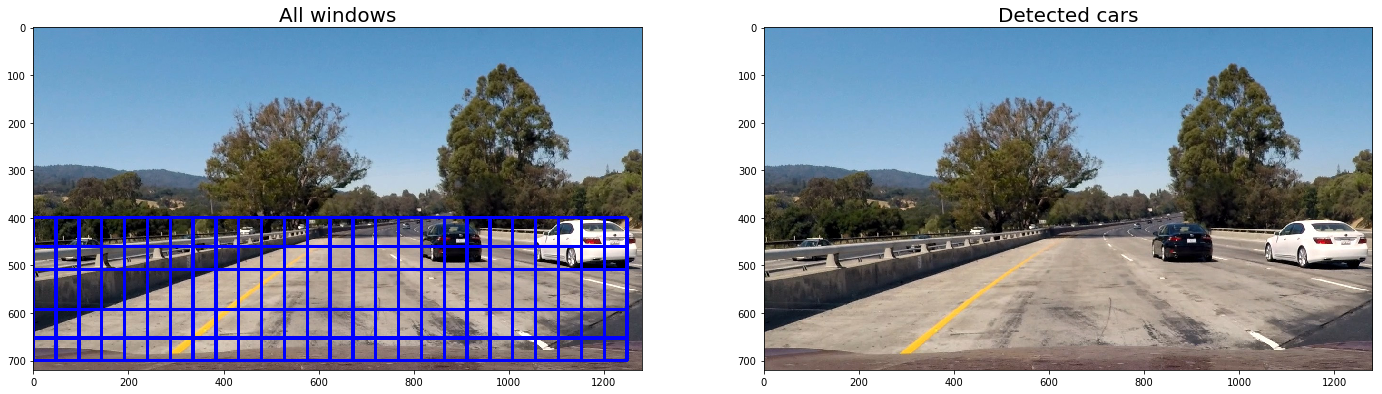

In [108]:
# Test - Nearer cars look bigger

image_file = './test_images/test1.jpg'
image = scipy.misc.imread(image_file)


all_rectangles = []
on_windows = []

# Parameters
ystart = 400
ystop = 600
scale = 3.0

all_rectangles.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=True))
on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))

ystart = 460
ystop = 700
scale = 3.0

all_rectangles.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=True))
on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))

rectangles = [item for sublist in all_rectangles for item in sublist] 
active_rectangles = [item for sublist in on_windows for item in sublist]

fig = plt.figure(figsize=(24,9))
plt.subplot(1,2,1)
test_out = draw_boxes(image, rectangles, (0,0,255), 6)
plt.imshow(test_out)
plt.title('All windows',fontsize=20)
plt.subplot(1,2,2);
test_out = draw_boxes(image, active_rectangles, (0,0,255), 6)
plt.imshow(test_out)
plt.title('Detected cars',fontsize=20)

save_image(fig, 'multiscaleWindows_near')


In [20]:
def find_cars_extended(image, window, cells_per_step,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False):
    on_windows = []

    ystart = 400
    ystop = 465
    scale = 1.0
    on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))
    
    ystart = 420
    ystop = 485
    scale = 1.0
    all_rectangles.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                        svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                         colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=True))
    on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                        svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                         colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))

    ystart = 400
    ystop = 500
    scale = 1.5
    on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))
    ystart = 430
    ystop = 530
    scale = 1.5
    on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))
    ystart = 400
    ystop = 530
    scale = 2.0
    on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))
    ystart = 430
    ystop = 560
    scale = 2.0
    on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                  colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))
    ystart = 400
    ystop = 600
    scale = 3.0
    on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))
    ystart = 460
    ystop = 700
    scale = 3.0
    on_windows.append(find_cars(image, window, cells_per_step, ystart, ystop, scale,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat,show_all_windows=False))

    rectangles = [item for sublist in on_windows for item in sublist] 
    return rectangles

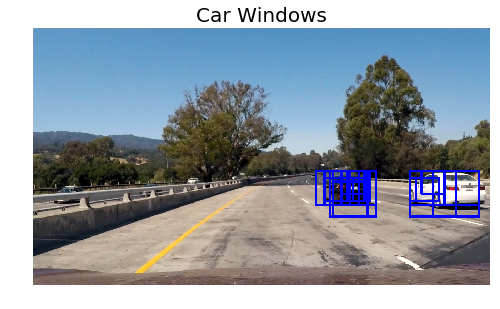

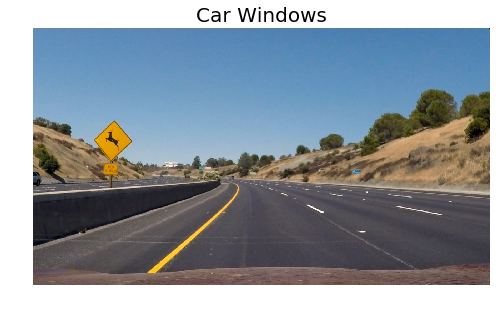

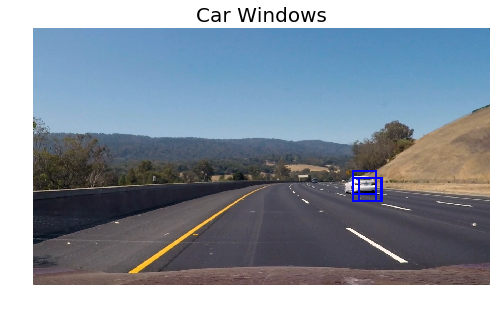

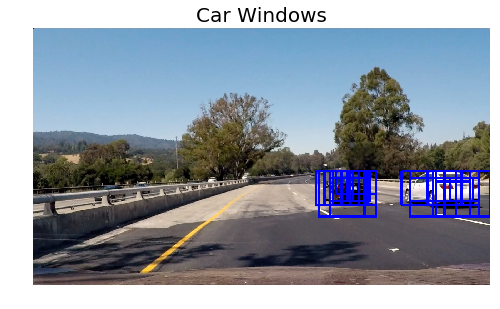

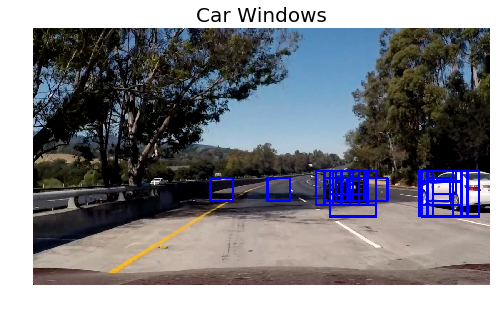

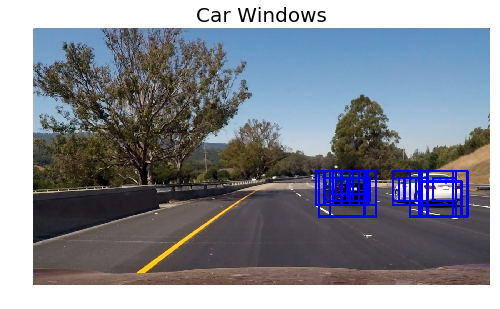

In [21]:
# Test
#image_file = './test_images/test3.jpg'
image_file = glob.glob('./test_images/test*.jpg')
i_img = 1
for file in image_file:
    image = scipy.misc.imread(file)

    # Find hot windows
    window=64
    cells_per_step=2
    box_list = find_cars_extended(image, window, cells_per_step,
                        svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                         colorspace, hog_channel, spatial_feat, hist_feat, hog_feat)
    # Draw bounding boxes on a copy of the image
    out_img = draw_boxes(np.copy(image), box_list)


    fig = plt.figure(figsize=(18,6))
    plt.subplot(122)
    plt.axis('off')
    plt.imshow(out_img)
    plt.title('Car Windows', fontsize=20)

    save_image(fig, ('multiscale_sliding_windows_'+str(i_img)))
    i_img = i_img + 1

## Multiple detections and false positives

### Combining overlapping bonding boxes

In [14]:
# Functions adapted from lectures

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



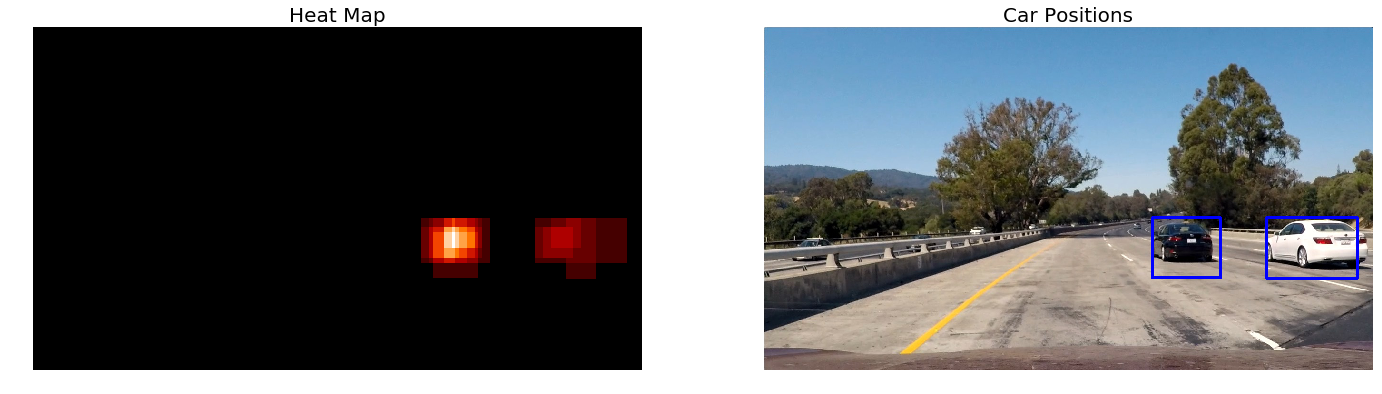

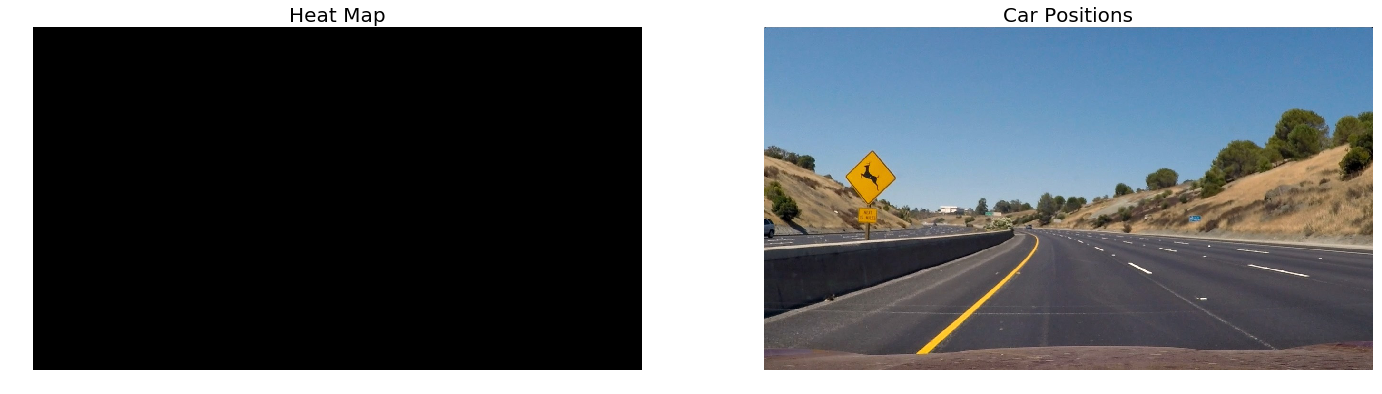

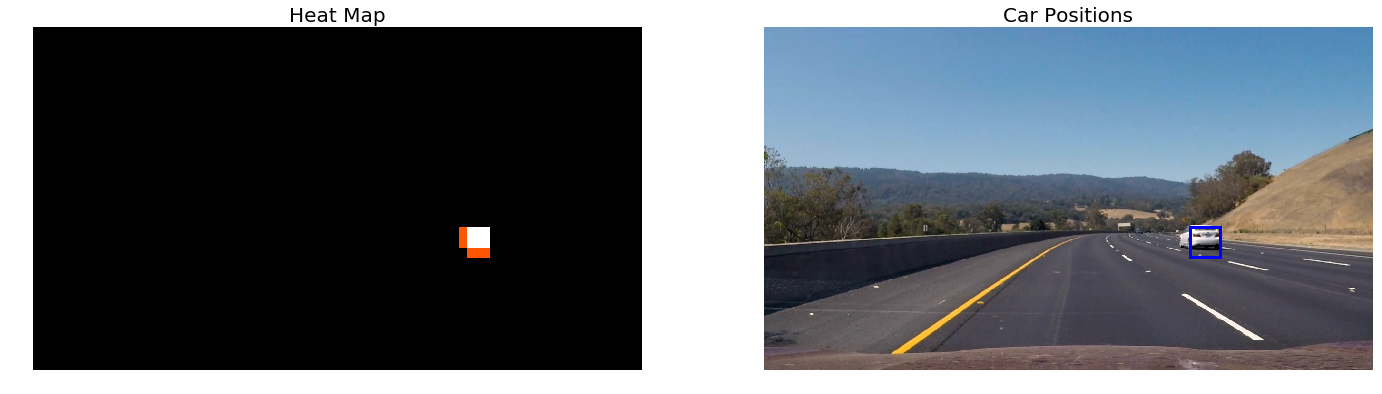

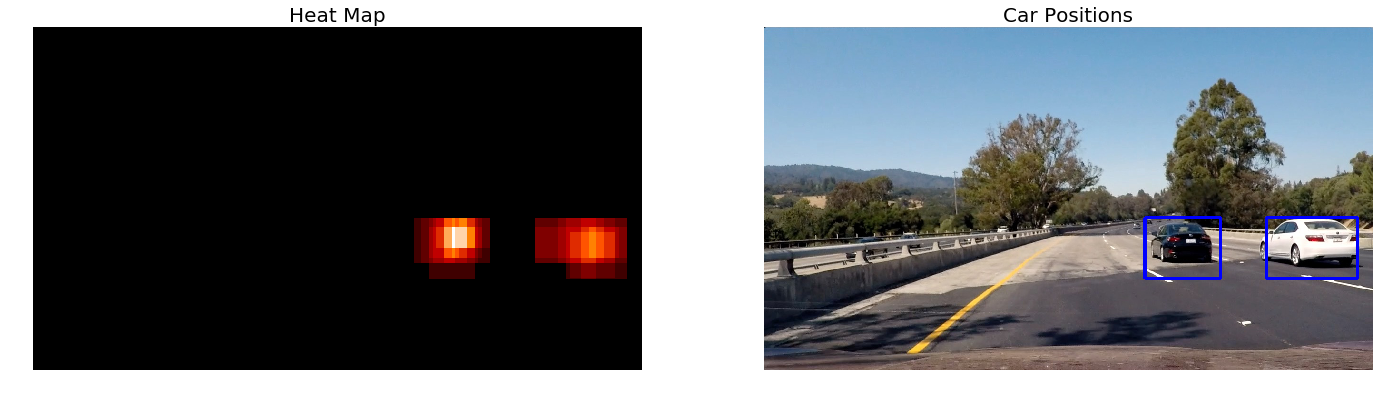

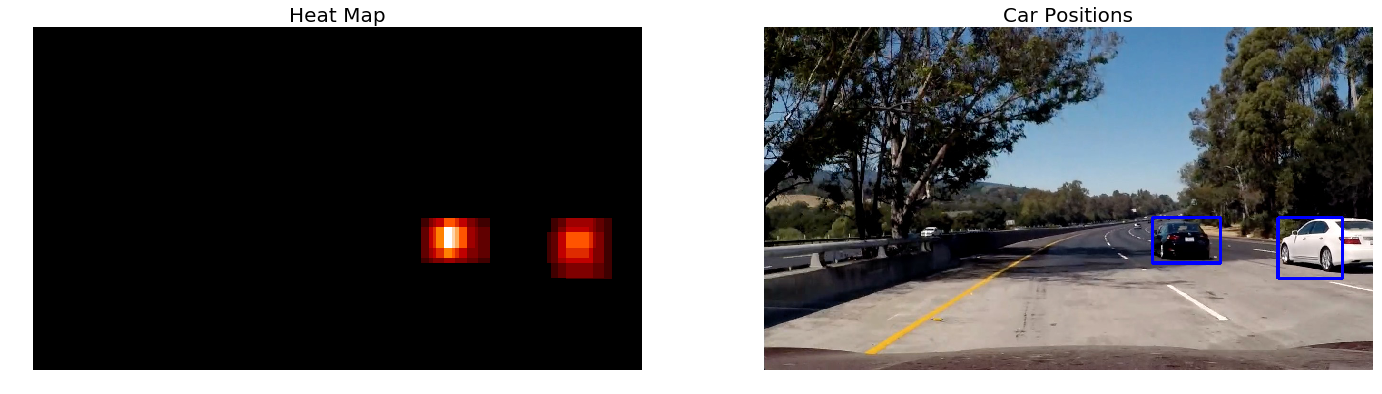

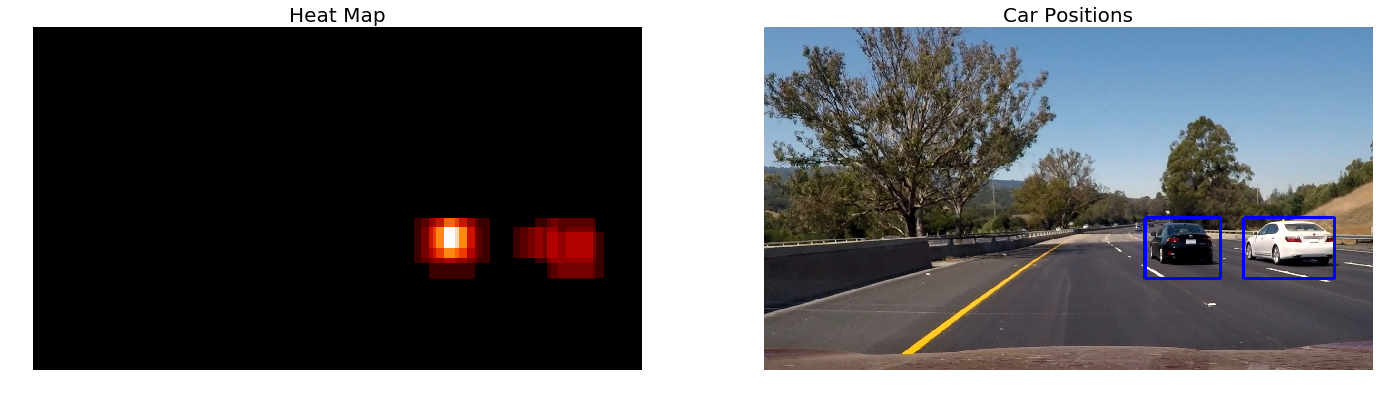

In [22]:
# Test
image_file = glob.glob('./test_images/test*.jpg')
i_img = 1
for file in image_file:
    #image_file = './test_images/test5.jpg'
    image = scipy.misc.imread(file)

    draw_image = np.copy(image)
    heatmap = np.zeros_like(draw_image[:,:,0]).astype(np.float)

    # Find hot windows
    box_list = find_cars_extended(image, window, cells_per_step,
                        svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                         colorspace, hog_channel, spatial_feat, hist_feat, hog_feat)

    # Add heat to each box in box list
    heat = add_heat(heatmap, box_list)

    # Apply threshold to help remove false positives
    heat_threshold = 1
    heat = apply_threshold(heat,heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    # Draw bounding boxes on a copy of the image
    out_img = draw_labeled_bboxes(draw_image, labels)


    fig = plt.figure(figsize=(24,9))
    plt.subplot(121)
    plt.axis('off')
    plt.imshow(heatmap, cmap='gist_heat')
    plt.title('Heat Map', fontsize=20)

    plt.subplot(122)
    plt.axis('off')
    plt.imshow(out_img)
    plt.title('Car Positions', fontsize=20)

    save_image(fig, 'heatmap' + str(i_img))
    i_img = i_img + 1

### Filtering out video frames


In [16]:
# Define a class to consider previous video frames in order to identify false positives
class DetectionHistory():
    def __init__(self):
        # n rectangles in memory
        self.n_history = 10
        # history of rectangles previous n frames
        self.prev_car_windows = [] 
        
    def add_car_windows(self, car_windows):
        self.prev_car_windows.append(car_windows)
        if len(self.prev_car_windows) > self.n_history:
            # throw out oldest rectangle set(s)
            self.prev_car_windows = self.prev_car_windows[len(self.prev_car_windows) - self.n_history:]
        

## Final video pipeline

In [25]:
def pipeline(image):
    heatmap = np.zeros_like(draw_image[:,:,0]).astype(np.float)

    # Find hot windows
    # Parameters
    window = 64 # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    cells_per_step = 2  # Instead of overlap, define how many cells to step => 75% overlap
    
    car_windows = find_cars_extended(image, window, cells_per_step,
                    svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                     colorspace, hog_channel, spatial_feat, hist_feat, hog_feat)

    # add detections to the history
    if len(car_windows) > 0:
        detection_history.add_car_windows(car_windows)
        
    for each_window in detection_history.prev_car_windows:
        heatmap = add_heat(heatmap, each_window)
    

    # Apply threshold to help remove false positives
    heat_threshold = 2
    heatmap = apply_threshold(heatmap, detection_history.n_history*heat_threshold)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    # Draw bounding boxes on a copy of the image
    out_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return out_img

In [26]:
detection_history = DetectionHistory()

white_output = 'result_test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")

white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video result_test_video.mp4
[MoviePy] Writing video result_test_video.mp4


 97%|█████████▋| 38/39 [00:27<00:00,  1.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_test_video.mp4 

CPU times: user 28.2 s, sys: 444 ms, total: 28.7 s
Wall time: 28.9 s


### Project video

In [27]:
detection_history = DetectionHistory()

white_output = 'result_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video result_project_video.mp4
[MoviePy] Writing video result_project_video.mp4


100%|█████████▉| 1260/1261 [15:23<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_project_video.mp4 

CPU times: user 15min 45s, sys: 14.2 s, total: 15min 59s
Wall time: 15min 25s
